# **Flight Cancellation Predictor ✈**

In [ ]:
# install packages
!pip install pandas
import pandas as pd
!pip install numpy
import numpy as np
!pip install holidays
import holidays
import os
from datetime import timedelta
from google.colab import drive

# autogluon
!pip install autogluon
from autogluon.tabular import TabularPredictor

# visuals
!pip install sweetviz
import sweetviz as sv
!pip install seaborn
!pip install matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# evaluation metrics
!pip install evaluate
import evaluate

# display settings
pd.options.display.width = None
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# **Import Data**
https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp
https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr

In [ ]:

# Set working directory
# import os
# os.getcwd()
# os.chdir("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course")

# Mount Google Drive and set path
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/HuggingFace_LiL_Course_2025'

# Gather CSVs based on naming convention
# https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFD%20&Yv0x=D
# Dictionary : https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ
csv_files = [f for f in os.listdir(data_dir) if f.startswith('T_ONTIME_REPORTING11') and f.endswith('.csv')] #T_ONTIME_REPORTING11

# Load each CSV into a dictionary of dfs
dataframes = {file: pd.read_csv(os.path.join(data_dir, file), low_memory=False) for file in csv_files}

# Confirm loaded files
print("Loaded files:", list(dataframes.keys()))

# Combine into single df
df = pd.concat(
    [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files],
    ignore_index=True
)

# Add in National Plan of Integrated Airport Systems (NPIAS) data : https://www.faa.gov/airports/planning_capacity/npias/current
# Dictionary : https://www.faa.gov/sites/faa.gov/files/airports/planning_capacity/npias/current/ARP-NPIAS-2025-2029-Appendix-A.pdf
excel_files = [f for f in os.listdir(data_dir) if f.startswith('ARP') and f.endswith('.xlsx')] #T_ONTIME_REPORTING11
dataframes = {file: pd.read_excel(os.path.join(data_dir, file)) for file in excel_files}
arp = pd.concat(
    [pd.read_excel(os.path.join(data_dir, file)) for file in excel_files],
    ignore_index=True
)
arp.head()

# Join to cancellation data. Note you are joining based on the ORIGIN airport!!!! NOTE: Could some feats come from destination???
df = pd.merge(df,arp,how='left',left_on='ORIGIN',right_on='LocID')


# Sample the df for modeling
df = df.sample(n=10000, random_state=123)
df.columns = df.columns.str.lower() # make cols lower case
df.head()

# Import data
# df = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING1.csv")
# df1 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING1.csv")
# df2 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING2.csv")
# df3 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING3.csv")
# df4 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING4.csv")
# df5 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING5.csv")
# df6 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING6.csv")
# df7 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING7.csv")
# df8 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING8.csv")
# df9 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING9.csv")
# df10 = pd.read_csv("c:\\Users\\18594\\Documents\\HuggingFace_LiL_Course\\T_ONTIME_REPORTING10.csv")

# # Combine dataframes
# df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], ignore_index=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded files: ['T_ONTIME_REPORTING11.csv']


/tmp/ipython-input-1361238595.py:23: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(data_dir, file)) for file in csv_files],


,year,quarter,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_airline_id,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_fips,origin_state_nm,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_fips,dest_state_nm,dest_wac,crs_dep_time,dep_time,dep_delay,dep_delay_new,dep_del15,dep_delay_group,dep_time_blk,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,arr_del15,arr_delay_group,arr_time_blk,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,div_airport_landings,div_reached_dest,div_actual_elapsed_time,div_arr_delay,div_distance,div1_airport,div1_airport_id,div1_airport_seq_id,div1_wheels_on,div1_total_gtime,div1_longest_gtime,div1_wheels_off,div1_tail_num,div2_airport,div2_airport_id,div2_airport_seq_id,div2_wheels_on,div2_total_gtime,div2_longest_gtime,div2_wheels_off,div2_tail_num,div3_airport,div3_airport_id,div3_airport_seq_id,div3_wheels_on,div3_total_gtime,div3_longest_gtime,div3_wheels_off,div3_tail_num,div4_airport,div4_airport_id,div4_airport_seq_id,div4_wheels_on,div4_total_gtime,div4_longest_gtime,div4_wheels_off,div4_tail_num,div5_airport,div5_airport_id,div5_airport_seq_id,div5_wheels_on,div5_total_gtime,div5_longest_gtime,div5_wheels_off,div5_tail_num,state,city,airport,locid,owner-\nship,svc lvl\n(fy25),hub\n(fy25),role\n(fy25),enplaned\n(cy23/fy25),based aircraft\n(fy25),development\nestimate\n2025-2029
161212,2024,2,6,9,7,6/9/2024 12:00:00 AM,AA,19805,AA,N5007E,790,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,12478,1247805,31703,JFK,"New York, NY",NY,36,New York,22,1700,1710.0000000000,10.0000000000,10.0000000000,0.0000000000,0.0000000000,1700-1759,28.0000000000,1738.0000000000,1856.0000000000,25.0000000000,1900,1921.0000000000,21.0000000000,21.0000000000,1.0000000000,1.0000000000,1900-1959,0.0000000000,NaN,0.0000000000,120.0000000000,131.0000000000,78.0000000000,1.0000000000,541.0000000000,3,4.0000000000,0.0000000000,11.0000000000,0.0000000000,6.0000000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North Carolina,Charlotte,Charlotte/Douglas International,CLT,PU,P,L,NaN,25896201.0000000000,84.0000000000,1034776873.0000000000
585492,2024,2,6,29,6,6/29/2024 12:00:00 AM,UA,19977,UA,N62896,502,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,12892,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91,745,738.0000000000,-7.0000000000,0.0000000000,0.0000000000,-1.0000000000,0700-0759,10.0000000000,748.0000000000,818.0000000000,31.0000000000,855,849.0000000000,-6.0000000000,0.0000000000,0.0000000000,-1.0000000000,0800-0859,0.0000000000,NaN,0.0000000000,190.0000000000,191.0000000000,150.0000000000,1.0000000000,1242.0000000000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Austin,Austin-Bergstrom International,AUS,PU,P,L,NaN,10833443.0000000000,152.0000000000,1047269147.0000000000
443375,2024,2,6,22,6,6/22/2024 12:00:00 AM,WN,19393,WN,N452WN,3179,13244,1324402,33244,MEM,"Memphis, TN",TN,47,Tennessee,54,15304,1530402,33195,TPA,"Tampa, FL",FL,12,Florida,33,1130,1137.0000000000,7.0000000000,7.0000000000,0.0000000000,0.0000000000,1100-1159,9.0000000000,1146.0000000000,1412.0000000000,5.0000000000,1420,1417.0000000000,-3.0000000000,0.0000000000,0.0000000000,-1.0000000000,1400-1459,0.0000000000,NaN,0.0000000000,110.0000000000,100.0000000000,86.0000000000,1.0000000000,655.0000000000,3,NaN,N

In [ ]:
df.head()

,year,quarter,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_airline_id,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_fips,origin_state_nm,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_fips,dest_state_nm,dest_wac,crs_dep_time,dep_time,dep_delay,dep_delay_new,dep_del15,dep_delay_group,dep_time_blk,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,arr_del15,arr_delay_group,arr_time_blk,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,div_airport_landings,div_reached_dest,div_actual_elapsed_time,div_arr_delay,div_distance,div1_airport,div1_airport_id,div1_airport_seq_id,div1_wheels_on,div1_total_gtime,div1_longest_gtime,div1_wheels_off,div1_tail_num,div2_airport,div2_airport_id,div2_airport_seq_id,div2_wheels_on,div2_total_gtime,div2_longest_gtime,div2_wheels_off,div2_tail_num,div3_airport,div3_airport_id,div3_airport_seq_id,div3_wheels_on,div3_total_gtime,div3_longest_gtime,div3_wheels_off,div3_tail_num,div4_airport,div4_airport_id,div4_airport_seq_id,div4_wheels_on,div4_total_gtime,div4_longest_gtime,div4_wheels_off,div4_tail_num,div5_airport,div5_airport_id,div5_airport_seq_id,div5_wheels_on,div5_total_gtime,div5_longest_gtime,div5_wheels_off,div5_tail_num,state,city,airport,locid,owner-\nship,svc lvl\n(fy25),hub\n(fy25),role\n(fy25),enplaned\n(cy23/fy25),based aircraft\n(fy25),development\nestimate\n2025-2029
161212,2024,2,6,9,7,6/9/2024 12:00:00 AM,AA,19805,AA,N5007E,790,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,12478,1247805,31703,JFK,"New York, NY",NY,36,New York,22,1700,1710.0000000000,10.0000000000,10.0000000000,0.0000000000,0.0000000000,1700-1759,28.0000000000,1738.0000000000,1856.0000000000,25.0000000000,1900,1921.0000000000,21.0000000000,21.0000000000,1.0000000000,1.0000000000,1900-1959,0.0000000000,NaN,0.0000000000,120.0000000000,131.0000000000,78.0000000000,1.0000000000,541.0000000000,3,4.0000000000,0.0000000000,11.0000000000,0.0000000000,6.0000000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North Carolina,Charlotte,Charlotte/Douglas International,CLT,PU,P,L,NaN,25896201.0000000000,84.0000000000,1034776873.0000000000
585492,2024,2,6,29,6,6/29/2024 12:00:00 AM,UA,19977,UA,N62896,502,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,12892,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91,745,738.0000000000,-7.0000000000,0.0000000000,0.0000000000,-1.0000000000,0700-0759,10.0000000000,748.0000000000,818.0000000000,31.0000000000,855,849.0000000000,-6.0000000000,0.0000000000,0.0000000000,-1.0000000000,0800-0859,0.0000000000,NaN,0.0000000000,190.0000000000,191.0000000000,150.0000000000,1.0000000000,1242.0000000000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Austin,Austin-Bergstrom International,AUS,PU,P,L,NaN,10833443.0000000000,152.0000000000,1047269147.0000000000
443375,2024,2,6,22,6,6/22/2024 12:00:00 AM,WN,19393,WN,N452WN,3179,13244,1324402,33244,MEM,"Memphis, TN",TN,47,Tennessee,54,15304,1530402,33195,TPA,"Tampa, FL",FL,12,Florida,33,1130,1137.0000000000,7.0000000000,7.0000000000,0.0000000000,0.0000000000,1100-1159,9.0000000000,1146.0000000000,1412.0000000000,5.0000000000,1420,1417.0000000000,-3.0000000000,0.0000000000,0.0000000000,-1.0000000000,1400-1459,0.0000000000,NaN,0.0000000000,110.0000000000,100.0000000000,86.0000000000,1.0000000000,655.0000000000,3,NaN,N

In [ ]:
# Feature ideas
# seasonality - around holiday
# carrier
# origin/destination airport
# day of week
# take off time
# accuracy metrics by airline
# direction of travel - east to west, pick up on tailwinds?
# either departing or arrival airport is a hub # https://www.faa.gov/airports/planning_capacity/categories
# nulls!!!!!!!!
# budget v non budget airlines

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 161212 to 182643
Columns: 120 entries, year to development
estimate
2025-2029
dtypes: float64(72), int64(21), object(27)
memory usage: 9.2+ MB


In [ ]:

df.describe()


,year,quarter,month,day_of_month,day_of_week,op_carrier_airline_id,op_carrier_fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin_state_fips,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest_state_fips,dest_wac,crs_dep_time,dep_time,dep_delay,dep_delay_new,dep_del15,dep_delay_group,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,arr_del15,arr_delay_group,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,div_airport_landings,div_reached_dest,div_actual_elapsed_time,div_arr_delay,div_distance,div1_airport_id,div1_airport_seq_id,div1_wheels_on,div1_total_gtime,div1_longest_gtime,div1_wheels_off,div2_airport_id,div2_airport_seq_id,div2_wheels_on,div2_total_gtime,div2_longest_gtime,div2_wheels_off,div3_airport,div3_airport_id,div3_airport_seq_id,div3_wheels_on,div3_total_gtime,div3_longest_gtime,div3_wheels_off,div3_tail_num,div4_airport,div4_airport_id,div4_airport_seq_id,div4_wheels_on,div4_total_gtime,div4_longest_gtime,div4_wheels_off,div4_tail_num,div5_airport,div5_airport_id,div5_airport_seq_id,div5_wheels_on,div5_total_gtime,div5_longest_gtime,div5_wheels_off,div5_tail_num,enplaned\n(cy23/fy25),based aircraft\n(fy25),development\nestimate\n2025-2029
count,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,9890.0000000000,9890.0000000000,9890.0000000000,9890.0000000000,9890.0000000000,9881.0000000000,9881.0000000000,9877.0000000000,9877.0000000000,10000.0000000000,9877.0000000000,9840.0000000000,9840.0000000000,9840.0000000000,9840.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,9840.0000000000,9840.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,2483.0000000000,2483.0000000000,2483.0000000000,2483.0000000000,2483.0000000000,90.0000000000,90.0000000000,90.0000000000,10000.0000000000,40.0000000000,37.0000000000,37.0000000000,40.0000000000,41.0000000000,41.0000000000,41.0000000000,41.0000000000,41.0000000000,38.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,9967.0000000000,9967.0000000000,9967.0000000000
mean,2024.0000000000,2.0000000000,6.0000000000,15.6223000000,4.1842000000,19951.0260000000,2539.3627000000,12644.2420000000,1264428.1580000001,31739.7830000000,27.2193000000,54.2517000000,12633.7353000000,1263377.4842999999,31729.3619000000,27.3445000000,54.4428000000,1342.1728000000,1344.3671385238,16.6046511628,19.3892821031,0.2532861476,0.4173913043,17.7810950309,1362.8276490234,1438.6587020350,8.6073706591,1482.0693000000,1440.7580236914,11.3644308943,19.0441056911,0.2523373984,0.1635162602,0.0120000000,0.0040000000,146.0196000000,140.8292682927,114.4649390244,1.0000000000,840.0874000000,3.8325000000,22.3044703987,4.2621828433,14.4973821990,0.1196133709,30.2319774466,1349.5000000000,46.3000000000,43.2666666667,0.0050000000,0.9250000000,389.9189189189,266.7837837838,7.8500000000,12919.2926829268,1291932.7804878049,1450.3170731707,40.6341463415,30.4634146341,1465.8421052632,14869.0000000000,1486903.0000000000,1555.0000000000,3.0000000000,3.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18149232.7727500759,69.7399418080,662172113.6546603441
std,0.0000000000,0.0000000000,0.0000000000,8.60962573

In [ ]:
# Cancellation Rate
df['cancelled'].value_counts(normalize=True)

,proportion
cancelled,
0.0000000000,0.9880000000
1.0000000000,0.0120000000


In [ ]:
# How many of each class
df['cancelled'].value_counts()

,count
cancelled,
0.0000000000,9880
1.0000000000,120


In [ ]:
df.shape

(10000, 120)

In [ ]:
# changes dtypes
df['cancelled'] = df['cancelled'].astype('category')
df['op_unique_carrier'] = df['op_unique_carrier'].astype('str')
df['op_carrier_airline_id'] = df['op_carrier_airline_id'].astype('str')
df['op_carrier'] = df['op_carrier'].astype('str')
df['op_carrier_fl_num'] = df['op_carrier_fl_num'].astype('str')

# if a col name starts with a given string, change dtype to string
for col in df.columns:
    if col.startswith('origin'):
        df[col] = df[col].astype('str')

for col in df.columns:
    if col.startswith('dest'):
        df[col] = df[col].astype('str')

df.dtypes

,0
year,int64
quarter,int64
month,int64
day_of_month,int64
day_of_week,int64
fl_date,object
op_unique_carrier,object
op_carrier_airline_id,object
op_carrier,object
tail_num,object


# ❌ NOTE: Any holidays I want to manually add????????????????????????????? ❌

In [ ]:
# holidays
# full list of supported holidays in over 50 countries -> https://pypi.org/project/holidays/
# NOTE: Any I want to manually add?????????????????????????????
US_holidays = holidays.US()

# preview list of reocgnized holidays for the years in our dataset
# you might want to append other relevant holidays that are not recognized in this list that may have an effect on sales
# such as Black Friday in the US or company/industry-specific holidays (ex: valentine's day may be more relevant for a jewler than a furniture store)
years = [2022,2023,2024,2025,2026]
for date in holidays.US(years=years).items():
  print(date)

# save the holidays as a separate string to compare against the df
US_Holidays = []
for date in holidays.US(years=years).items():
   US_Holidays.append(str(date[0]))

# create a separare date value type so we can compare to the holidays string list
df['fl_date_dt'] =  pd.to_datetime(df['fl_date'])
# Check if the dates in the 'date' column are holidays
df['ind_is_holiday'] = df['fl_date_dt'].apply(lambda x: US_holidays.get(x.date()) is not None) # marks w true false
# # mark date as 1 if it falls on a US holiday, zero otherwise
df['ind_is_holiday'] = np.where(df['ind_is_holiday']==True, 1.0, 0.0)

# Check if the dates in the 'date' column are within X days of a holiday
df['ind_is_near_holiday_down'] = df['fl_date_dt'].apply(lambda x: any((x.date() - timedelta(days=i)) in US_holidays for i in range(3)))
df['ind_is_near_holiday_up'] = df['fl_date_dt'].apply(lambda x: any((x.date() + timedelta(days=i)) in US_holidays for i in range(3)))

df['ind_is_near_holiday'] = np.where((df['ind_is_near_holiday_down']==True) | (df['ind_is_near_holiday_up']==True), 1.0, 0.0)
#df.head(50)

(datetime.date(2022, 1, 1), "New Year's Day")
(datetime.date(2022, 5, 30), 'Memorial Day')
(datetime.date(2022, 6, 19), 'Juneteenth National Independence Day')
(datetime.date(2022, 6, 20), 'Juneteenth National Independence Day (observed)')
(datetime.date(2022, 7, 4), 'Independence Day')
(datetime.date(2022, 9, 5), 'Labor Day')
(datetime.date(2022, 11, 11), 'Veterans Day')
(datetime.date(2022, 11, 24), 'Thanksgiving Day')
(datetime.date(2022, 12, 25), 'Christmas Day')
(datetime.date(2022, 12, 26), 'Christmas Day (observed)')
(datetime.date(2022, 1, 17), 'Martin Luther King Jr. Day')
(datetime.date(2022, 2, 21), "Washington's Birthday")
(datetime.date(2022, 10, 10), 'Columbus Day')
(datetime.date(2023, 1, 1), "New Year's Day")
(datetime.date(2023, 1, 2), "New Year's Day (observed)")
(datetime.date(2023, 5, 29), 'Memorial Day')
(datetime.date(2023, 6, 19), 'Juneteenth National Independence Day')
(datetime.date(2023, 7, 4), 'Independence Day')
(datetime.date(2023, 9, 4), 'Labor Day')
(date

/tmp/ipython-input-3040624679.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fl_date_dt'] =  pd.to_datetime(df['fl_date'])


In [ ]:
# Calculate proximity to/from a holiday
def days_until_next_holiday(flight_date, holiday_calendar):

    # Sort holiday list so that the next holiday can be found
    future_holidays = sorted([d for d in holiday_calendar if d >= flight_date.date()])

    # If there is no next holiday, return None (this shouldn't happen since we included future years)
    if not future_holidays:
        return None

    # Find the next holiday date
    next_holiday = future_holidays[0]

    # Calculate days difference
    days_diff = (next_holiday - flight_date.date()).days
    return days_diff

df['days_until_holiday'] = df['fl_date_dt'].apply(lambda x: days_until_next_holiday(x, US_holidays))


def days_since_last_holiday(flight_date, holiday_calendar):

    # Sort holiday list so that the next holiday can be found
    past_holidays = sorted([d for d in holiday_calendar if d <= flight_date.date()])

    # If there is no next holiday, return None (this shouldn't happen since we included prior years)
    if not past_holidays:
        return None

    # Find the next holiday date
    last_holiday = past_holidays[0]

    # Calculate days difference
    days_diff = (flight_date.date() - last_holiday).days
    return days_diff

df['days_since_last_holiday'] = df['fl_date_dt'].apply(lambda x: days_since_last_holiday(x, US_holidays))
df.head()

,year,quarter,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_airline_id,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_fips,origin_state_nm,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_fips,dest_state_nm,dest_wac,crs_dep_time,dep_time,dep_delay,dep_delay_new,dep_del15,dep_delay_group,dep_time_blk,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,arr_del15,arr_delay_group,arr_time_blk,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,div_airport_landings,div_reached_dest,div_actual_elapsed_time,div_arr_delay,div_distance,div1_airport,div1_airport_id,div1_airport_seq_id,div1_wheels_on,div1_total_gtime,div1_longest_gtime,div1_wheels_off,div1_tail_num,div2_airport,div2_airport_id,div2_airport_seq_id,div2_wheels_on,div2_total_gtime,div2_longest_gtime,div2_wheels_off,div2_tail_num,div3_airport,div3_airport_id,div3_airport_seq_id,div3_wheels_on,div3_total_gtime,div3_longest_gtime,div3_wheels_off,div3_tail_num,div4_airport,div4_airport_id,div4_airport_seq_id,div4_wheels_on,div4_total_gtime,div4_longest_gtime,div4_wheels_off,div4_tail_num,div5_airport,div5_airport_id,div5_airport_seq_id,div5_wheels_on,div5_total_gtime,div5_longest_gtime,div5_wheels_off,div5_tail_num,state,city,airport,locid,owner-\nship,svc lvl\n(fy25),hub\n(fy25),role\n(fy25),enplaned\n(cy23/fy25),based aircraft\n(fy25),development\nestimate\n2025-2029,fl_date_dt,ind_is_holiday,ind_is_near_holiday_down,ind_is_near_holiday_up,ind_is_near_holiday,days_until_holiday,days_since_last_holiday
161212,2024,2,6,9,7,6/9/2024 12:00:00 AM,AA,19805,AA,N5007E,790,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,12478,1247805,31703,JFK,"New York, NY",NY,36,New York,22,1700,1710.0000000000,10.0000000000,10.0000000000,0.0000000000,0.0000000000,1700-1759,28.0000000000,1738.0000000000,1856.0000000000,25.0000000000,1900,1921.0000000000,21.0000000000,21.0000000000,1.0000000000,1.0000000000,1900-1959,0.0000000000,NaN,0.0000000000,120.0000000000,131.0000000000,78.0000000000,1.0000000000,541.0000000000,3,4.0000000000,0.0000000000,11.0000000000,0.0000000000,6.0000000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North Carolina,Charlotte,Charlotte/Douglas International,CLT,PU,P,L,NaN,25896201.0000000000,84.0000000000,1034776873.0000000000,2024-06-09,0.0000000000,False,False,0.0000000000,10,160
585492,2024,2,6,29,6,6/29/2024 12:00:00 AM,UA,19977,UA,N62896,502,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,12892,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91,745,738.0000000000,-7.0000000000,0.0000000000,0.0000000000,-1.0000000000,0700-0759,10.0000000000,748.0000000000,818.0000000000,31.0000000000,855,849.0000000000,-6.0000000000,0.0000000000,0.0000000000,-1.0000000000,0800-0859,0.0000000000,NaN,0.0000000000,190.0000000000,191.0000000000,150.0000000000,1.0000000000,1242.0000000000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Austin,Austin-Bergstrom International,AUS,PU,P,L,NaN,10833443.0000000000,152.0000000000,1047269147.0000000000,2024-06-29,0.0000000000,False,False,0.0000000000,5,180
443375,2024,2,6,22,6,6/22/2024 12:00:00 AM,WN,19393,WN,N452WN,3179,13244,1324402,33244,MEM,"Memphis, TN",TN,47,Tennessee,54,15304,1530402,33195,TPA,"Tampa, FL",FL,12,Florida,33,1130,1137.0000000000,7.0000000000,7.0000000000,0.0000000000,0.0000000000,1100-1159,9.00


# **Feature Creations**



In [ ]:

# Check for missing values, impute where necessary
df.isnull().sum()

,0
year,0
quarter,0
month,0
day_of_month,0
day_of_week,0
fl_date,0
op_unique_carrier,0
op_carrier_airline_id,0
op_carrier,0
tail_num,20


In [ ]:
# get hour from departure and arrival times
df['scheduled_hour_of_departure'] = df['crs_dep_time'].astype(str).str.zfill(4).str.slice(0, 2).astype(int)
df['scheduled_hour_of_arrival'] = df['crs_arr_time'].astype(str).str.zfill(4).str.slice(0, 2).astype(int)

# indicator variables
df['ind_is_local'] = np.where(df['role\n(fy25)'] == 'Local', 1, 0) # maybe these airports dont have many resources to prevent cancellations if something goes wrong
df['ind_is_summer'] = np.where((df['month'] >= 6) & (df['month'] <= 8), 1, 0)
df['ind_late_scheduled_hour_of_departure'] = np.where((df['scheduled_hour_of_departure'] >= 20) & (df['scheduled_hour_of_departure'] <= 22), 1, 0)
df['ind_late_scheduled_hour_of_arrival'] = np.where((df['scheduled_hour_of_arrival'] >= 21) & (df['scheduled_hour_of_arrival'] <= 23), 1, 0)
df['ind_early_departure'] = np.where(df['dep_delay'] < 0, 1, 0)

df.head()

,year,quarter,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_airline_id,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin,origin_city_name,origin_state_abr,origin_state_fips,origin_state_nm,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest,dest_city_name,dest_state_abr,dest_state_fips,dest_state_nm,dest_wac,crs_dep_time,dep_time,dep_delay,dep_delay_new,dep_del15,dep_delay_group,dep_time_blk,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,arr_del15,arr_delay_group,arr_time_blk,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,div_airport_landings,div_reached_dest,div_actual_elapsed_time,div_arr_delay,div_distance,div1_airport,div1_airport_id,div1_airport_seq_id,div1_wheels_on,div1_total_gtime,div1_longest_gtime,div1_wheels_off,div1_tail_num,div2_airport,div2_airport_id,div2_airport_seq_id,div2_wheels_on,div2_total_gtime,div2_longest_gtime,div2_wheels_off,div2_tail_num,div3_airport,div3_airport_id,div3_airport_seq_id,div3_wheels_on,div3_total_gtime,div3_longest_gtime,div3_wheels_off,div3_tail_num,div4_airport,div4_airport_id,div4_airport_seq_id,div4_wheels_on,div4_total_gtime,div4_longest_gtime,div4_wheels_off,div4_tail_num,div5_airport,div5_airport_id,div5_airport_seq_id,div5_wheels_on,div5_total_gtime,div5_longest_gtime,div5_wheels_off,div5_tail_num,state,city,airport,locid,owner-\nship,svc lvl\n(fy25),hub\n(fy25),role\n(fy25),enplaned\n(cy23/fy25),based aircraft\n(fy25),development\nestimate\n2025-2029,fl_date_dt,ind_is_holiday,ind_is_near_holiday_down,ind_is_near_holiday_up,ind_is_near_holiday,days_until_holiday,days_since_last_holiday,scheduled_hour_of_departure,scheduled_hour_of_arrival,ind_is_local,ind_is_summer,ind_late_scheduled_hour_of_departure,ind_late_scheduled_hour_of_arrival,ind_early_departure
161212,2024,2,6,9,7,6/9/2024 12:00:00 AM,AA,19805,AA,N5007E,790,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,12478,1247805,31703,JFK,"New York, NY",NY,36,New York,22,1700,1710.0000000000,10.0000000000,10.0000000000,0.0000000000,0.0000000000,1700-1759,28.0000000000,1738.0000000000,1856.0000000000,25.0000000000,1900,1921.0000000000,21.0000000000,21.0000000000,1.0000000000,1.0000000000,1900-1959,0.0000000000,NaN,0.0000000000,120.0000000000,131.0000000000,78.0000000000,1.0000000000,541.0000000000,3,4.0000000000,0.0000000000,11.0000000000,0.0000000000,6.0000000000,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,North Carolina,Charlotte,Charlotte/Douglas International,CLT,PU,P,L,NaN,25896201.0000000000,84.0000000000,1034776873.0000000000,2024-06-09,0.0000000000,False,False,0.0000000000,10,160,17,19,0,1,0,0,0
585492,2024,2,6,29,6,6/29/2024 12:00:00 AM,UA,19977,UA,N62896,502,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,12892,1289208,32575,LAX,"Los Angeles, CA",CA,6,California,91,745,738.0000000000,-7.0000000000,0.0000000000,0.0000000000,-1.0000000000,0700-0759,10.0000000000,748.0000000000,818.0000000000,31.0000000000,855,849.0000000000,-6.0000000000,0.0000000000,0.0000000000,-1.0000000000,0800-0859,0.0000000000,NaN,0.0000000000,190.0000000000,191.0000000000,150.0000000000,1.0000000000,1242.0000000000,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Texas,Austin,Austin-Bergstrom International,AUS,PU,P,L,NaN,10833443.0000000000,152.0000000000,1047269147.0000000000,2024-06-29,0.0000000000,False,False,0.0000000000,5,180,7,8,0,1,0,0,1
443375,2024,2,6,22,6,6/22/2024 12:00:00 AM,WN,19393,WN,N452WN

# See Cancellation Rate across categorical variables

In [ ]:
from IPython.display import display
datax = df.copy()
datax['ones'] = 1
total_trxns = len(datax)
datax['num_cancelled'] = np.where(datax['cancelled'].isin([1]), 1, 0)
datax['num_non_cancelled'] = np.where(datax['cancelled'].isin([0]), 1, 0)
# create 'proc freq' table for each var
def freq_table1(var):
    datay = datax[[var,'num_cancelled','num_non_cancelled','ones']]
    datay = datay.rename(columns={'ones': 'total_count'})
    datay = datay.groupby([var], as_index=False).sum()
    datay['cancelled_rate'] = datay['num_cancelled'] / datay['total_count'] * 100
    datay['percent_total'] = datay['total_count'] / total_trxns * 100
    #datay = datay.loc[datay['num_bad'] >= 10]
    datay_sorted = datay.sort_values(by='cancelled_rate', ascending=False)
    return datay_sorted
display(freq_table1('quarter'))

,quarter,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
0,2,120,9880,10000,1.2000000000,100.0000000000


In [ ]:
display(freq_table1('op_unique_carrier'))

,op_unique_carrier,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
0,9E,9,287,296,3.0405405405,2.9600000000
9,NK,9,380,389,2.3136246787,3.8900000000
1,AA,32,1357,1389,2.3038156947,13.8900000000
8,MQ,9,385,394,2.2842639594,3.9400000000
3,B6,7,330,337,2.0771513353,3.3700000000
5,F9,6,300,306,1.9607843137,3.0600000000
14,YX,8,410,418,1.9138755981,4.1800000000
10,OH,5,301,306,1.6339869281,3.0600000000
12,UA,14,1011,1025,1.3658536585,10.2500000000
7,HA,1,100,101,0.9900990099,1.0100000000


In [ ]:
# display(freq_table1('origin'))

In [ ]:
# display(freq_table1('dest'))

In [ ]:
display(freq_table1('owner-\nship'))

,owner-\nship,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
0,MA,1,71,72,1.3888888889,0.7200000000
2,PU,119,9772,9891,1.2031139420,98.9100000000
1,MR,0,4,4,0.0000000000,0.0400000000


In [ ]:
display(freq_table1('hub\n(fy25)'))

,hub\n(fy25),num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
2,N,7,483,490,1.4285714286,4.9000000000
0,L,83,6390,6473,1.2822493434,64.7300000000
1,M,18,1751,1769,1.0175240249,17.6900000000
3,S,11,1221,1232,0.8928571429,12.3200000000


In [ ]:
display(freq_table1('role\n(fy25)'))

,role\n(fy25),num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
0,Regional,1,2,3,33.3333333333,0.0300000000


In [ ]:
display(freq_table1('op_unique_carrier'))

,op_unique_carrier,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
0,9E,9,287,296,3.0405405405,2.9600000000
9,NK,9,380,389,2.3136246787,3.8900000000
1,AA,32,1357,1389,2.3038156947,13.8900000000
8,MQ,9,385,394,2.2842639594,3.9400000000
3,B6,7,330,337,2.0771513353,3.3700000000
5,F9,6,300,306,1.9607843137,3.0600000000
14,YX,8,410,418,1.9138755981,4.1800000000
10,OH,5,301,306,1.6339869281,3.0600000000
12,UA,14,1011,1025,1.3658536585,10.2500000000
7,HA,1,100,101,0.9900990099,1.0100000000


In [ ]:
display(freq_table1('scheduled_hour_of_departure'))

,scheduled_hour_of_departure,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
2,2,1,2,3,33.3333333333,0.0300000000
19,21,10,402,412,2.4271844660,4.1200000000
18,20,11,463,474,2.3206751055,4.7400000000
20,22,6,293,299,2.0066889632,2.9900000000
15,17,12,623,635,1.8897637795,6.3500000000
13,15,11,605,616,1.7857142857,6.1600000000
10,12,10,555,565,1.7699115044,5.6500000000
12,14,8,501,509,1.5717092338,5.0900000000
4,6,10,687,697,1.4347202296,6.9700000000
16,18,8,596,604,1.3245033113,6.0400000000


In [ ]:
display(freq_table1('scheduled_hour_of_arrival'))

,scheduled_hour_of_arrival,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
21,21,14,566,580,2.4137931034,5.8000000000
23,23,13,528,541,2.4029574861,5.4100000000
6,6,4,165,169,2.3668639053,1.6900000000
16,16,11,531,542,2.0295202952,5.4200000000
22,22,8,501,509,1.5717092338,5.0900000000
19,19,8,623,631,1.2678288431,6.3100000000
13,13,7,577,584,1.1986301370,5.8400000000
15,15,6,501,507,1.1834319527,5.0700000000
7,7,5,443,448,1.1160714286,4.4800000000
20,20,6,561,567,1.0582010582,5.6700000000


In [ ]:
display(freq_table1('day_of_week'))

,day_of_week,num_cancelled,num_non_cancelled,total_count,cancelled_rate,percent_total
2,3,34,1260,1294,2.6275115920,12.9400000000
6,7,36,1698,1734,2.0761245675,17.3400000000
3,4,12,1337,1349,0.8895478132,13.4900000000
5,6,12,1562,1574,0.7623888183,15.7400000000
1,2,8,1217,1225,0.6530612245,12.2500000000
0,1,9,1388,1397,0.6442376521,13.9700000000
4,5,9,1418,1427,0.6306937631,14.2700000000


# **Visuals**

In [ ]:
# # Isolate cols you want to analyze - sweetviz can get slow with too many cols
# feature_cols = [c for c in df.columns if c.startswith("days")]

# # Separate numeric and object columns
# numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
# object_cols = [c for c in feature_cols if pd.api.types.is_object_dtype(df[c])]

# for col in numeric_cols:
#     df[col] = pd.to_numeric(df[col], errors='coerce')

# # Fill nas with 0
# df[numeric_cols] = df[numeric_cols].fillna(0)

# # Ensure target var is integer
# df['cancelled'] = pd.to_numeric(df['cancelled'], errors='coerce').fillna(0).astype(int)

# # Split into cancelled and non-cancelled subsets
# df_0 = df[df['cancelled'] == 0].copy()
# df_1 = df[df['cancelled'] == 1].copy()

# # Ensure both subsets have the same columns
# df_0_features = df_0[numeric_cols + object_cols].copy()
# df_1_features = df_1[numeric_cols + object_cols].copy()

# # Force Sweetviz to treat object columns as categorical
# feature_config = sv.FeatureConfig(force_cat=object_cols)

# # Run report
# report = sv.compare(df_0_features, df_1_features, feat_cfg=feature_config)
# report.show_html("cancellation_report.html")


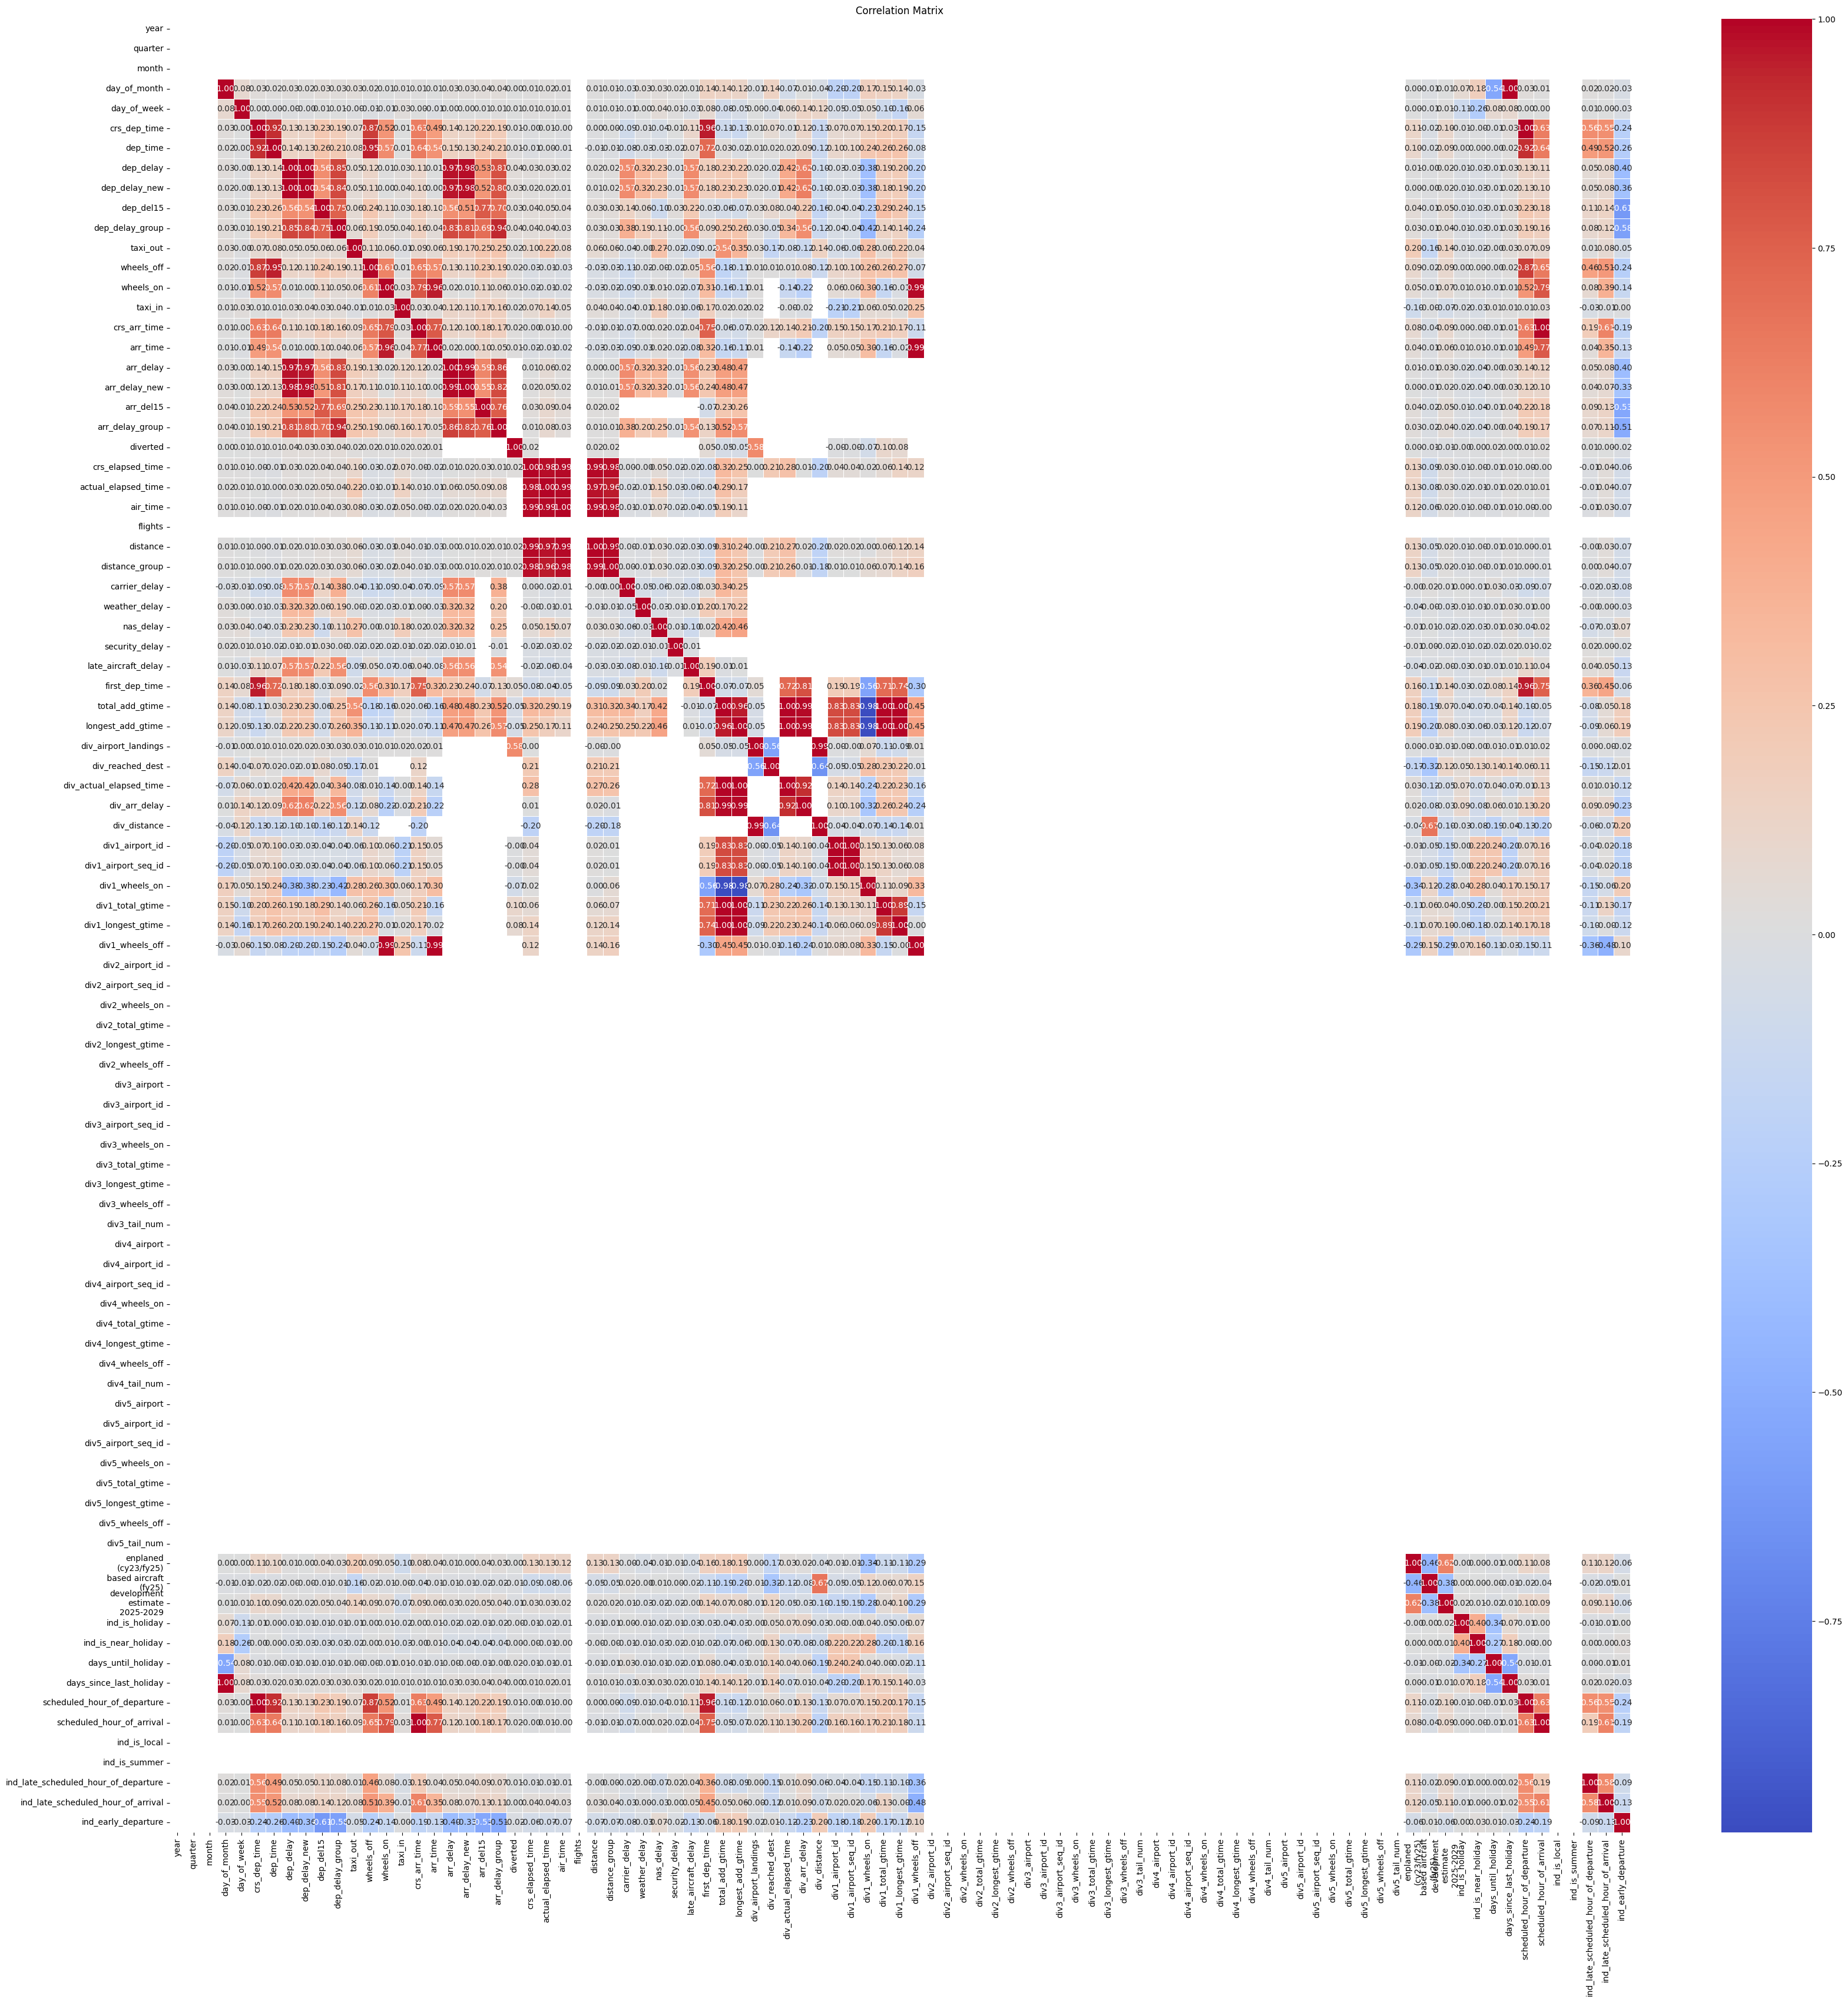

In [ ]:
# Correlation Matrix
# Select numeric cols only
numeric_df = df.select_dtypes(include='number')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# **AutoGluon**
-- Notice here that the train test split looks a little different than what you weould see from sklearn. You do not have to explicitly separate out X from y
- label = target variable
- eval metric - this is the metric you want to prioritize in the trainig phases

In [ ]:
# Keep only variables of interest
#df.columns.tolist() # can use this to get list of all cols, then paste below + flexibly comment in and out what you want to send through the model
df = df[[

# date/time features
'year',
 'quarter',
 'month',
 'day_of_month',
 'day_of_week',
 'scheduled_hour_of_departure',
 'scheduled_hour_of_arrival',
  'fl_date_dt',

 # 'op_unique_carrier', # use for airline carrier
#  'op_carrier_airline_id',
#  'op_carrier',
# 'tail_num', # unique identifier for the aircraft
#  'op_carrier_fl_num',
#  'origin_airport_id',
#  'origin_airport_seq_id',
#  'origin_city_market_id',
 'origin',
#  'origin_city_name',
#  'origin_state_abr',
#  'origin_state_fips',
#  'origin_state_nm',
#  'origin_wac',
#  'dest_airport_id',
#  'dest_airport_seq_id',
#  'dest_city_market_id',
 'dest',
#  'dest_city_name',
#  'dest_state_abr',
#  'dest_state_fips',
#  'dest_state_nm',
#  'dest_wac',
# 'crs_dep_time', # converted into scheduled departure hour
# 'dep_time', # actual departure time, redundant with dep delay
 'dep_delay', # early departures are negative
 'dep_delay_new', # What is the difference between this and dep delay? is one a better predictor than the other?
 'dep_del15',
 'dep_delay_group',
 # 'dep_time_blk',
 # 'taxi_out', # not known pre flight
 # 'wheels_off', # not known pre flight
 # 'wheels_on', # not informative
 'taxi_in',
# 'crs_arr_time',  # converted into scheduled arrival hour
#  'arr_time', # not known pre flight
#  'arr_delay', # not known pre flight
#  'arr_delay_new', # not known pre flight
#  'arr_del15', # not known pre flight
#  'arr_delay_group', # not known pre flight
#  'arr_time_blk', # not known pre flight
 'cancelled', # TARGET VARIABLE, DO NOT REMOVE
 # 'cancellation_code', # LEAKAGE, DO NOT INCLUDE
 # 'diverted', # would not necessarily be known at the time of flight
 'crs_elapsed_time', # estimated time of scheduled flight
# 'actual_elapsed_time',  # not known pre flight
 # 'air_time', # not known pre flight
 'flights',
 'distance', # Distance between airports (miles)
 'distance_group',
 'carrier_delay', # in Minutes
 'weather_delay', # in Minutes
 'nas_delay', # National Air System Delay, in Minutes
 'security_delay', # in Minutes
 'late_aircraft_delay', # in Minutes
# 'first_dep_time',
#  'total_add_gtime', # do not use, data leakage
#  'longest_add_gtime', # do not use, data leakage

  # Diverted flight features - removing these bc this information is not necessarily known at time of flight - not sure if this info is collected in real time, or only after flight is complete
#  'div_airport_landings',
#  'div_reached_dest',
#  'div_actual_elapsed_time',
#  'div_arr_delay',
#  'div_distance',
#  'div1_airport',
#  'div1_airport_id',
#  'div1_airport_seq_id',
#  'div1_wheels_on',
#  'div1_total_gtime',
#  'div1_longest_gtime',
#  'div1_wheels_off',
#  'div1_tail_num',
#  'div2_airport',
#  'div2_airport_id',
#  'div2_airport_seq_id',
#  'div2_wheels_on',
#  'div2_total_gtime',
#  'div2_longest_gtime',
#  'div2_wheels_off',
#  'div2_tail_num',
#  'div3_airport',
#  'div3_airport_id',
#  'div3_airport_seq_id',
#  'div3_wheels_on',
#  'div3_total_gtime',
#  'div3_longest_gtime',
#  'div3_wheels_off',
#  'div3_tail_num',
#  'div4_airport',
#  'div4_airport_id',
#  'div4_airport_seq_id',
#  'div4_wheels_on',
#  'div4_total_gtime',
#  'div4_longest_gtime',
#  'div4_wheels_off',
#  'div4_tail_num',
#  'div5_airport',
#  'div5_airport_id',
#  'div5_airport_seq_id',
#  'div5_wheels_on',
#  'div5_total_gtime',
#  'div5_longest_gtime',
#  'div5_wheels_off',
#  'div5_tail_num',

# HOLIDAYS
 'ind_is_holiday',
 'ind_is_near_holiday_down',
 'ind_is_near_holiday_up',
 'ind_is_near_holiday',
 'days_until_holiday',
 'days_since_last_holiday',
 'ind_is_summer',

# OTHER IND VARIABLES
 'ind_late_scheduled_hour_of_departure',
 'ind_late_scheduled_hour_of_arrival',
 'ind_early_departure'
]]
df.head()

,year,quarter,month,day_of_month,day_of_week,scheduled_hour_of_departure,scheduled_hour_of_arrival,fl_date_dt,origin,dest,dep_delay,dep_delay_new,dep_del15,dep_delay_group,taxi_in,cancelled,crs_elapsed_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,ind_is_holiday,ind_is_near_holiday_down,ind_is_near_holiday_up,ind_is_near_holiday,days_until_holiday,days_since_last_holiday,ind_is_summer,ind_late_scheduled_hour_of_departure,ind_late_scheduled_hour_of_arrival,ind_early_departure
161212,2024,2,6,9,7,17,19,2024-06-09,CLT,JFK,10.0000000000,10.0000000000,0.0000000000,0.0000000000,25.0000000000,0.0000000000,120.0000000000,1.0000000000,541.0000000000,3,4.0000000000,0.0000000000,11.0000000000,0.0000000000,6.0000000000,0.0000000000,False,False,0.0000000000,10,160,1,0,0,0
585492,2024,2,6,29,6,7,8,2024-06-29,AUS,LAX,-7.0000000000,0.0000000000,0.0000000000,-1.0000000000,31.0000000000,0.0000000000,190.0000000000,1.0000000000,1242.0000000000,5,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,5,180,1,0,0,1
443375,2024,2,6,22,6,11,14,2024-06-22,MEM,TPA,7.0000000000,7.0000000000,0.0000000000,0.0000000000,5.0000000000,0.0000000000,110.0000000000,1.0000000000,655.0000000000,3,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,12,173,1,0,0,0
156139,2024,2,6,8,6,10,11,2024-06-08,BWI,ISP,22.0000000000,22.0000000000,1.0000000000,1.0000000000,3.0000000000,0.0000000000,70.0000000000,1.0000000000,220.0000000000,1,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,11,159,1,0,0,0
52106,2024,2,6,3,1,16,0,2024-06-03,LAX,EWR,4.0000000000,4.0000000000,0.0000000000,0.0000000000,5.0000000000,0.0000000000,330.0000000000,1.0000000000,2454.0000000000,10,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,16,154,1,0,0,0


In [ ]:
# # Sample and split the data into train and test sets
from sklearn.model_selection import train_test_split
df = df.sample(n=10000)
train, test = train_test_split(df, test_size=0.4, train_size=0.6, random_state=123)
df.shape

(10000, 35)

In [ ]:
# make sure we are using TabPFNMix
# https://dataloop.ai/library/model/autogluon_tabpfn-mix-10-regressor/
tabpfnmix_cfg = {
    "model_path_regressor": "autogluon/tabpfn-mix-1.0-regressor",
    "n_ensembles": 1,
    "max_epochs": 3, # NOTE: change this
}

hyperparameters = {
    "TABPFNMIX": [tabpfnmix_cfg]
}

# Fit the model
predictor = TabularPredictor(label='cancelled', eval_metric='roc_auc').fit(
    train_data=train,
    tuning_data=test,
    hyperparameters=hyperparameters,
    presets=None,
    use_bag_holdout=True,
    num_bag_folds=0,
    num_bag_sets=0,
    num_stack_levels=0,
    verbosity = 4, # determines how detailed you want output logs to be
    ag_args_fit={"ag.max_memory_usage_ratio": 5} # optional, helps prevent out of memory errors
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251003_050832"
Verbosity: 4 (Maximum Logging)
loky.cpu_count(only_physical_cores=False): 2
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       7.61 GB / 12.67 GB (60.0%)
Disk Space Avail:   59.04 GB / 107.72 GB (54.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accurac

# **Model Evaluation**

In [ ]:
# Out of the box metrics
# Report a variety of metrics on a separate test dataset
predictor.leaderboard(test,silent=True, extra_metrics=['f1','roc_auc','precision','recall'])

Loading: /content/AutogluonModels/ag-20251003_050832/models/TabPFNMix/model.pkl
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loading: /content/AutogluonModels/ag-20251003_050832/models/WeightedEnsemble_L2/model.pkl
Model scores:
{'TabPFNMix': np.float64(0.9972024848516906), 'WeightedEnsemble_L2': np.float64(0.9972024848516906)}


,model,score_test,f1,roc_auc,precision,recall,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,TabPFNMix,0.9972024849,0.9761904762,0.9972024849,1.0000000000,0.9534883721,0.9972024849,roc_auc,243.0943810940,235.5342426300,1221.7030627728,243.0943810940,235.5342426300,1221.7030627728,1,True,1
1,WeightedEnsemble_L2,0.9972024849,0.9761904762,0.9972024849,1.0000000000,0.9534883721,0.9972024849,roc_auc,243.1411004066,235.5365915298,1221.7316489220,0.0467193127,0.0023488998,0.0285861492,2,True,2


Add column using predictions from the best performing model to your dataset

In [ ]:
# Add prediciton values for each row as a column in the dataset. Could do this process with multiple models to compare if you wanted to
chosen_model = 'TabPFNMix'
train['pred']=predictor.predict(train,model=chosen_model)
test['pred']=predictor.predict(test,model=chosen_model)

# Return the class probabilities for classification
test['pred_proba_0']=predictor.predict_proba(test,model=chosen_model)[0]
test['pred_proba_1']=predictor.predict_proba(test,model=chosen_model)[1]
train['pred_proba_0']=predictor.predict_proba(train,model=chosen_model)[0]
train['pred_proba_1']=predictor.predict_proba(train,model=chosen_model)[1]

# # # edit decision threshold
# thres= 0.46
# test['pred']= np.where(test['pred_proba_1']>=thres,1,0)
# train['pred']= np.where(train['pred_proba_1']>=thres,1,0)

Loading: /content/AutogluonModels/ag-20251003_050832/models/TabPFNMix/model.pkl
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loading: /content/AutogluonModels/ag-20251003_050832/models/TabPFNMix/model.pkl
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loading: /content/AutogluonModels/ag-20251003_050832/models/TabPFNMix/model.pkl
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Loading: /content/AutogluonModels/ag-20251003_050832/models/TabPFNMix/model.pkl
/usr/local/lib

In [ ]:
test.head()

,year,quarter,month,day_of_month,day_of_week,scheduled_hour_of_departure,scheduled_hour_of_arrival,fl_date_dt,origin,dest,dep_delay,dep_delay_new,dep_del15,dep_delay_group,taxi_in,cancelled,crs_elapsed_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,ind_is_holiday,ind_is_near_holiday_down,ind_is_near_holiday_up,ind_is_near_holiday,days_until_holiday,days_since_last_holiday,ind_is_summer,ind_late_scheduled_hour_of_departure,ind_late_scheduled_hour_of_arrival,ind_early_departure,pred,pred_proba_0,pred_proba_1
138805,2024,2,6,7,5,12,15,2024-06-07,SJU,MCO,-5.0000000000,0.0000000000,0.0000000000,-1.0000000000,7.0000000000,0.0000000000,185.0000000000,1.0000000000,1189.0000000000,5,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,12,158,1,0,0,1,0,0.9998936057,0.0001063648
334102,2024,2,6,17,1,13,16,2024-06-17,PHX,SEA,-3.0000000000,0.0000000000,0.0000000000,-1.0000000000,8.0000000000,0.0000000000,184.0000000000,1.0000000000,1107.0000000000,5,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,True,1.0000000000,2,168,1,0,0,1,0,0.9995663762,0.0004336221
169523,2024,2,6,9,7,16,18,2024-06-09,PHX,SBA,-2.0000000000,0.0000000000,0.0000000000,-1.0000000000,4.0000000000,0.0000000000,93.0000000000,1.0000000000,455.0000000000,2,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,10,160,1,0,0,1,0,0.9999654889,0.0000344978
432645,2024,2,6,22,6,21,22,2024-06-22,ATL,DEN,-4.0000000000,0.0000000000,0.0000000000,-1.0000000000,15.0000000000,0.0000000000,199.0000000000,1.0000000000,1199.0000000000,5,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,12,173,1,1,1,1,0,0.9993024468,0.0006975382
4688,2024,2,6,1,6,7,9,2024-06-01,MCO,LGA,-2.0000000000,0.0000000000,0.0000000000,-1.0000000000,10.0000000000,0.0000000000,165.0000000000,1.0000000000,950.0000000000,4,NaN,NaN,NaN,NaN,NaN,0.0000000000,False,False,0.0000000000,18,152,1,0,0,1,0,0.9994021058,0.0005979241


# **Hugging Face's Evaluate Library**

In [ ]:
# import metrics
auc = evaluate.load("roc_auc")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# gather predicted and true values
predictions = test['pred'].values.tolist()
true_labels = test['cancelled'].tolist()

# Calculate metrics
auc = auc.compute(prediction_scores=predictions, references=true_labels)
# f1 = f1.compute(prediction_scores=predictions, references=true_labels)
# precision = precision.compute(prediction_scores=predictions, references=true_labels)
# recall = recall.compute(prediction_scores=predictions, references=true_labels)

print("AUC:", auc)
# print("F1:", f1)
# print("Precision:", precision)
# print("Recall:", recall)


AUC: {'roc_auc': np.float64(0.9767441860465116)}


## **Results by Class**

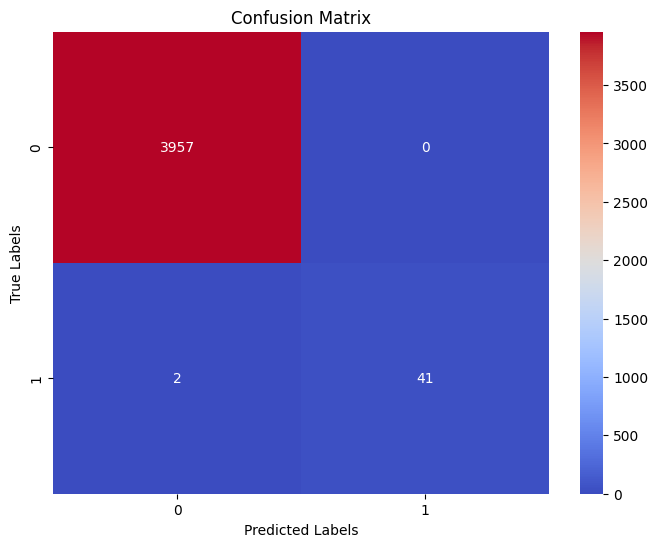

In [ ]:
# Going Deeper: Results by Class
confusion_matrix_metric = evaluate.load("confusion_matrix")
results = confusion_matrix_metric.compute(predictions=predictions, references=true_labels)

# Extract matrix and labels
matrix = np.array(results['confusion_matrix'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Calibration Thresholds
# Use training dataset to determine appropriate pred proba cutoff for classifications. We can incorporate this cutoff to the test dataset in the next model run
X_train = train.sort_values(by='pred_proba_1', ascending=False)
pd.options.display.float_format = '{:.10f}'.format
num_chunks = 100

# Calculate the chunk size
chunk_size = len(X_train) // num_chunks

# Split the dataframe into smaller chunks
chunks = [ X_train.iloc[i:i+chunk_size,:] for i in range(0, len( X_train), chunk_size)]

chunk = []
obs = []
score_range = []
events_count = []
pct_events = []
# Calculate values from each chunk
for i in range(0,num_chunks):
    # Perform your calculations on the chunk
    chunk.append(i)
    obs.append(len(chunks[i]))
    score_min = np.min(chunks[i]['pred_proba_1'])
    score_range.append(score_min)
    chunks[i]['cancelled'] = chunks[i]['cancelled'].astype(float)
    events = np.sum(chunks[i]['cancelled'])
    events_count.append(events)
    pct_events.append(events/len(chunks[i]))


/tmp/ipython-input-931960858.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunks[i]['cancelled'] = chunks[i]['cancelled'].astype(float)
/tmp/ipython-input-931960858.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunks[i]['cancelled'] = chunks[i]['cancelled'].astype(float)
/tmp/ipython-input-931960858.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [ ]:
chunk_properties = pd.DataFrame({'chunk': chunk, 'observations': obs, 'score_min': score_range, 'count of cancellations': events_count, 'cancellation rate': pct_events})

In [ ]:
chunk_properties

,chunk,observations,score_min,count of cancellations,cancellation rate
0,0,60,0.9982443452,60.0000000000,1.0000000000
1,1,60,0.0288859103,13.0000000000,0.2166666667
2,2,60,0.0168928932,1.0000000000,0.0166666667
3,3,60,0.0074493736,0.0000000000,0.0000000000
4,4,60,0.0040237708,0.0000000000,0.0000000000
5,5,60,0.0027254894,0.0000000000,0.0000000000
6,6,60,0.0019588128,0.0000000000,0.0000000000
7,7,60,0.0015208955,1.0000000000,0.0166666667
8,8,60,0.0012708111,0.0000000000,0.0000000000
9,9,60,0.0011577252,0.0000000000,0.0000000000


# **Feature Importance Plots**